In [17]:
%matplotlib widget
import scipy
import numpy as np
import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In [2]:
ais_final = gpd.read_file('basins/shapefiles/ANT_basins_thresh1000.shp')
gris_final = gpd.read_file('basins/shapefiles/GRE_basins_thresh2000.shp')

bc = ais_final.loc[ais_final.Subregions=='B-C']
cw = gris_final.loc[gris_final.SUBREGION1=='CW']

In [5]:
def get_masked_runoff(dataset, region, year, grid_resolution=1000, fac=0.05):

    xr = region.bounds.maxx.iloc[0] - region.bounds.minx.iloc[0]
    yr = region.bounds.maxy.iloc[0] - region.bounds.miny.iloc[0]
    xl = [region.bounds.minx.iloc[0]-fac*xr, region.bounds.maxx.iloc[0]+fac*xr]
    yl = [region.bounds.miny.iloc[0]-fac*yr, region.bounds.maxy.iloc[0]+fac*yr]
    subset = dataset.sel(x=slice(xl[0],xl[1]),y=slice(yl[0],yl[1]))
    
    grid_x = np.arange(subset.x.min(), subset.x.max()+grid_resolution, grid_resolution)
    grid_y = np.arange(subset.y.min(), subset.y.max()+grid_resolution, grid_resolution)
    transform = rio.Affine(grid_resolution, 0.0, grid_x.min()-0.5*grid_resolution,
                           0.0, grid_resolution, grid_y.min()-0.5*grid_resolution)
    
    ru = subset.sel(time=slice(year,year+1.0)).Ru
    ru.attrs["units"] = "meters of ice equivalant per year"
    ru_year = ru.mean(dim="time", skipna=True)
    rbs = scipy.interpolate.RectBivariateSpline(subset.x, subset.y, ru_year)
    resampled = np.transpose(rbs(grid_x, grid_y))
    resampled[resampled<=0.0] = np.nan
    masked_runoff = mask_array(resampled, region, transform)
    return grid_x, grid_y, masked_runoff


def mask_array(array, gdf, transform):
    
    # Create a mask using the shapefile
    mask = rio.features.geometry_mask(
        [geom for geom in gdf.geometry],
        out_shape=array.shape,
        transform=transform,
        invert=False
    )
    
    # Apply the mask to the array
    masked_array = np.copy(array)
    masked_array[mask] = np.nan
    
    return masked_array

<Axes: >

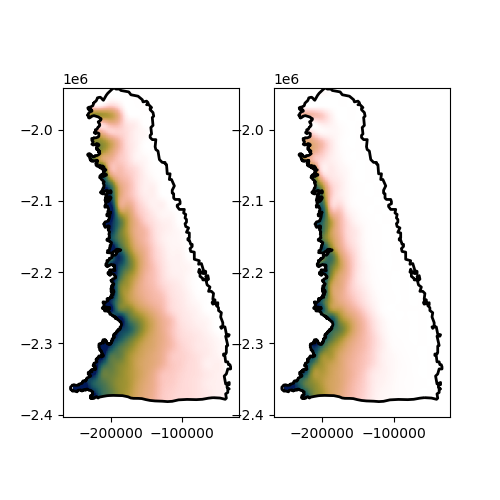

In [10]:
ds = xr.open_dataset('data/fdm/gsfc_fdm_smb_v1_2_1_gris_June22.nc')

fig, axs = plt.subplots(figsize=[5,5],ncols=2)

ax = axs[0]
xs, ys, ru19 = get_masked_runoff(dataset=ds, region=cw, year=2019, grid_resolution=1000, fac=0.0)
ax.pcolormesh(xs, ys, ru19, cmap=cmc.batlowW_r, shading='nearest', vmin=0, vmax=5)
cw.boundary.plot(ax=ax, color='k', lw=2)

ax = axs[1]
xs, ys, ru20 = get_masked_runoff(dataset=ds, region=cw, year=2020, grid_resolution=1000, fac=0.0)
ax.pcolormesh(xs, ys, ru20, cmap=cmc.batlowW_r, shading='nearest', vmin=0, vmax=5)
cw.boundary.plot(ax=ax, color='k', lw=2)

In [47]:
ds = xr.open_dataset('data/fdm/gsfc_fdm_smb_v1_2_1_June22.nc')

region = bc
dataset = ds 
fac = 0.0
xrng = region.bounds.maxx.iloc[0] - region.bounds.minx.iloc[0]
yrng = region.bounds.maxy.iloc[0] - region.bounds.miny.iloc[0]
xl = [region.bounds.minx.iloc[0]-fac*xrng, region.bounds.maxx.iloc[0]+fac*xrng]
yl = [region.bounds.miny.iloc[0]-fac*yrng, region.bounds.maxy.iloc[0]+fac*yrng]
selector = (dataset.x >= xl[0]) & (dataset.x <= xl[1]) & (dataset.y >= yl[0]) & (dataset.y <= yl[1])
subset = dataset.where(selector)

# fig,axs = plt.subplots(figsize=[5,5],ncols=2)

# ax = axs[0]
# xs, ys, ru19 = get_masked_runoff(dataset=ds, region=bc, year=2018.5, grid_resolution=1000, fac=0.0)
# ax.pcolormesh(xs, ys, ru19, cmap=cmc.batlowW_r, shading='nearest', vmin=0, vmax=5)
# cw.boundary.plot(ax=ax, color='k', lw=2)

# ax = axs[1]
# xs, ys, ru20 = get_masked_runoff(dataset=ds, region=bc, year=2020.5, grid_resolution=1000, fac=0.0)
# ax.pcolormesh(xs, ys, ru20, cmap=cmc.batlowW_r, shading='nearest', vmin=0, vmax=5)
# cw.boundary.plot(ax=ax, color='k', lw=2)

KeyboardInterrupt: 

In [ ]:
subset

In [45]:
ds = xr.open_dataset('data/fdm/gsfc_fdm_smb_v1_2_1_June22.nc')
ds.set_coords(["x", "y", "time"])

<xarray.Dataset>
Dimensions:  (x: 441, y: 401, time: 3104)
Coordinates:
    x        (x, y) int32 ...
    y        (x, y) int32 ...
  * time     (time) float32 1.98e+03 1.98e+03 1.98e+03 ... 2.022e+03 2.022e+03
Data variables:
    SMB      (time, x, y) float32 ...
    Me       (time, x, y) float32 ...
    Sn-Ev    (time, x, y) float32 ...
    Ra       (time, x, y) float32 ...
    Ru       (time, x, y) float32 ...
Attributes:
    creation_date:  25-Aug-2022 13:52:28
    title:          GSFC-FDMv1.2.1 Surface Mass Balance
    institution:    NASA Goddard Space Flight Center (GSFC)
    source:         version 1.2.1
    references:     Medley, B., Neumann, T. A., Zwally, H. J., and Smith, B. ...

In [44]:
ds.set_index(x=["x"])

ValueError: dimension mismatch: try setting an index for dimension 'x' with variable 'x' that has dimensions ('x', 'y')

In [37]:
ds = xr.open_dataset('data/fdm/gsfc_fdm_smb_v1_2_1_June22.nc')

data = xr.DataArray(
    [[1, 2], [3, 4]],
    dims=("x", "y"),
    coords={"x": [0, 1], "y": [5, 6]},
)
data

<xarray.DataArray (x: 2, y: 2)>
array([[1, 2],
       [3, 4]])
Coordinates:
  * x        (x) int64 0 1
  * y        (y) int64 5 6

In [40]:
data.set_index(y="y")

<xarray.DataArray (x: 2, y: 2)>
array([[1, 2],
       [3, 4]])
Coordinates:
  * x        (x) int64 0 1
  * y        (y) int64 5 6

In [26]:
from xarray import Index
from xarray.core.indexes import PandasIndex
from xarray.core.indexing import merge_sel_results


class RasterIndex(Index):
    def __init__(self, xy_indexes):
        assert len(xy_indexes) == 2

        # must have two distinct dimensions
        dim = [idx.dim for idx in xy_indexes.values()]
        assert dim[0] != dim[1]

        self._xy_indexes = xy_indexes

    @classmethod
    def from_variables(cls, variables):
        assert len(variables) == 2

        xy_indexes = {
            k: PandasIndex.from_variables({k: v}) for k, v in variables.items()
        }

        return cls(xy_indexes)

    def create_variables(self, variables):
        idx_variables = {}

        for index in self._xy_indexes.values():
            idx_variables.update(index.create_variables(variables))

        return idx_variables

    def sel(self, labels):
        results = []

        for k, index in self._xy_indexes.items():
            if k in labels:
                results.append(index.sel({k: labels[k]}))

        return merge_sel_results(results)

In [20]:
ds = xr.open_dataset('data/fdm/gsfc_fdm_smb_v1_2_1_gris_June22.nc')
ds

<xarray.Dataset>
Dimensions:  (x: 441, y: 281, time: 3104)
Coordinates:
  * x        (x) int32 -2940690 -2928190 -2915690 ... 2534309 2546809 2559309
  * y        (y) int32 -3929601 -3917101 -3904601 ... -454601 -442101 -429601
  * time     (time) float32 1.98e+03 1.98e+03 1.98e+03 ... 2.022e+03 2.022e+03
Data variables:
    SMB      (time, x, y) float32 ...
    Me       (time, x, y) float32 ...
    Sn-Ev    (time, x, y) float32 ...
    Ra       (time, x, y) float32 ...
    Ru       (time, x, y) float32 ...
Attributes:
    creation_date:  26-Aug-2022 15:54:39
    title:          GSFC-FDMv1.2.1 Surface Mass Balance
    institution:    NASA Goddard Space Flight Center (GSFC)
    source:         version 1.2.1
    references:     Medley, B., Neumann, T. A., Zwally, H. J., and Smith, B. ...

In [ ]:
xl = (-794440.390476191, 987172.1895545311)
yl = (-3383713.6847926266, -633391.6030721972)
gr = ds.sel(x=slice(xl[0],xl[1]),y=slice(yl[0],yl[1]))

ru = gr.sel(time=slice(2019,2020)).Ru
ru.attrs["units"] = "meters of ice equivalant per year"
ru19 = ru.sum(dim="time", skipna=True)

ru = gr.sel(time=slice(2020,2021)).Ru
ru.attrs["units"] = "meters of ice equivalant per year"
ru20 = ru.sum(dim="time", skipna=True)

fig,axs = plt.subplots(figsize=[9,6],ncols=2)

ax = axs[0]
rup = np.transpose(np.array(ru19))
rup[rup<1] = np.nan
X, Y = np.meshgrid(ru19.y, ru19.x)
ax.pcolormesh(ru19.x, ru19.y, rup, cmap=cmc.batlow_r, shading='nearest', vmin=0, vmax=200)
gris_final.boundary.plot(ax=ax, color='k', lw=0.5)

ax = axs[1]
rup = np.transpose(np.array(ru20))
rup[rup<1] = np.nan
X, Y = np.meshgrid(ru20.y, ru20.x)
ax.pcolormesh(ru20.x, ru20.y, rup, cmap=cmc.batlow_r, shading='nearest', vmin=0, vmax=200)
gris_final.boundary.plot(ax=ax, color='k', lw=0.5)

In [ ]:

xr = cw.bounds[2] - cw.bounds[0]
yr = cw.bounds[3] - cw.bounds[1]
fac = 0.1
xl = [cw.bounds[0]-fac*xr, cw.bounds[2]+fac*xr]
yl = [cw.bounds[1]-fac*yr, cw.bounds[3]+fac*yr]
gr = ds.sel(x=slice(xl[0],xl[1]),y=slice(yl[0],yl[1]))

grid_resolution = 1000
grid_x = np.arange(gr.x.min(), gr.x.max()+grid_resolution, grid_resolution)
grid_y = np.arange(gr.y.min(), gr.y.max()+grid_resolution, grid_resolution)
transform = rio.Affine(grid_resolution, 0.0, grid_x.min()-0.5*grid_resolution,
                       0.0, grid_resolution, grid_y.min()-0.5*grid_resolution)

ru = gr.sel(time=slice(2019,2020)).Ru
ru.attrs["units"] = "meters of ice equivalant per year"
ru19 = ru.mean(dim="time", skipna=True)
rbs = scipy.interpolate.RectBivariateSpline(gr.x, gr.y, ru19)
res19 = rbs(grid_x, grid_y)

ru = gr.sel(time=slice(2020,2021)).Ru
ru.attrs["units"] = "meters of ice equivalant per year"
ru20 = ru.mean(dim="time", skipna=True)
rbs = scipy.interpolate.RectBivariateSpline(gr.x, gr.y, ru20)
res20 = rbs(grid_x, grid_y)

fig,axs = plt.subplots(figsize=[9,6],ncols=2)

ax = axs[0]
rup = np.transpose(np.array(res19))
rup[rup<=0.1] = np.nan
plot19 = mask_array(rup, gris_final.loc[gris_final.SUBREGION1=='CW'], transform)
ax.pcolormesh(grid_x, grid_y, plot19, cmap=cmc.batlowW_r, shading='nearest', vmin=0, vmax=5)
gris_final.loc[gris_final.SUBREGION1=='CW'].boundary.plot(ax=ax, color='k', lw=2)

ax = axs[1]
rup = np.transpose(np.array(res20))
rup[rup<=0.1] = np.nan
ax.pcolormesh(grid_x, grid_y, rup, cmap=cmc.batlowW_r, shading='nearest', vmin=0, vmax=5)
gris_final.loc[gris_final.SUBREGION1=='CW'].boundary.plot(ax=ax, color='k', lw=2)


In [ ]:
grid_resolution = 1000
grid_x = np.arange(ru.x.min(), ru.x.max()+grid_resolution, grid_resolution)
grid_y = np.arange(ru.y.min(), ru.y.max()+grid_resolution, grid_resolution)
X, Y = np.meshgrid(ru.y, ru.x)
Xmesh, Ymesh = np.meshgrid(grid_x, grid_y, indexing='ij')
points = np.array(df_sd[['x_img', 'y_img']])
np.transpose(np.array(ru19))
# # sd_interp = griddata(points, sd_clip, (Xmesh, Ymesh), method='linear')
# sd_interp = griddata(points, sd_clip, (Xmesh, Ymesh), method='cubic')


In [ ]:
import rasterio as rio

In [ ]:
# bbox_size = (height, width)
# bbox = [left, bottom, right, top]
# transform = rasterio.transform.from_bounds(
#         *bbox, width=bbox_size[1], height=bbox_size[0]
#     )

bbox = [grid_x.min()-0.5*grid_resolution, 
        grid_y.min()-0.5*grid_resolution, 
        grid_x.max()+0.5*grid_resolution, 
        grid_y.max()+0.5*grid_resolution]
transform = rio.transform.from_bounds(*bbox, width=len(grid_x), height=len(grid_y))
transform

In [ ]:
len(grid_x)

In [ ]:
xx, yy = np.meshgrid(grid_x, grid_y)
geom = gris_final.loc[gris_final.SUBREGION1=='CW']
mask = shapely.vectorized.contains(geom, xx, yy)

In [ ]:

import shapely.vectorized

In [ ]:
grid_resolution = 1000
grid_x = np.arange(ru.x.min(), ru.x.max()+grid_resolution, grid_resolution)
grid_y = np.arange(ru.y.min(), ru.y.max()+grid_resolution, grid_resolution)
rbs = scipy.interpolate.RectBivariateSpline(ru.x, ru.y, ru19)
res = rbs(grid_x, grid_y)

In [ ]:
fig,ax = plt.subplots(figsize=[6,6])
ax.pcolormesh(res)

In [ ]:
ru = ds.sel(time=slice(2019,2020), y=slice(cw.bounds[2],cw.bounds[0]), x=slice(cw.bounds[1],cw.bounds[3])).Ru
# ru = ds.sel(time=slice(2019,2020)).Ru
ru.attrs["units"] = "meters of ice equivalant per year"
ru19 = ru.sum(dim="time", skipna=True)
# ru19 = np.array(ru19)
# ru19[ru19==0] = np.nan
# ru19.plot(cmap='afmhot')

fig,ax = plt.subplots(figsize=[6,6])
rup = np.transpose(np.array(ru19))
rup = np.array(ru19)
rup[rup==0] = np.nan
plt.pcolormesh(ru19.y, ru19.x, np.transpose(np.array(rup)), cmap=cmc.batlow_r)
gris_final.loc[gris_final.SUBREGION1=='CW'].boundary.plot(ax=ax)

In [ ]:
ru19